In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import time as time
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

!pip install modelsummary
from modelsummary import summary

import warnings
warnings.filterwarnings('ignore')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(9)

  Created wheel for modelsummary: filename=modelsummary-1.1.7-cp36-none-any.whl size=6955 sha256=0f8e791b514549f1289e0a32e9e3fbddeb357638fafce280898f53115794b4f9
  Stored in directory: /root/.cache/pip/wheels/fc/d3/e8/1ed6d9523b8480be97ccded9ecfed3413e84c73dae12bcc329
Successfully built modelsummary


# 1.  Preparation

从hw3中拿出数据和模型。进行本次实验。

In [3]:
# down dataset
# !gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip # 下載資料集
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# %cp gdrive/My\ Drive/food-11.zip ./
%cp gdrive/My\ Drive/food-11.zip ./
# !unzip food-11.zip 
!unzip food-11.zip 

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: food-11/training/4_165.jpg  
  inflating: food-11/training/5_376.jpg  
  inflating: food-11/training/2_691.jpg  
  inflating: food-11/training/0_541.jpg  
  inflating: food-11/training/3_482.jpg  
  inflating: food-11/training/0_227.jpg  
  inflating: food-11/training/5_410.jpg  
  inflating: food-11/training/4_603.jpg  
  inflating: food-11/training/8_341.jpg  
  inflating: food-11/training/5_1154.jpg  
  inflating: food-11/training/9_37.jpg  
  inflating: food-11/training/9_152.jpg  
  inflating: food-11/training/5_438.jpg  
  inflating: food-11/training/9_1287.jpg  
  inflating: food-11/training/8_369.jpg  
  inflating: food-11/training/2_1455.jpg  
  inflating: food-11/training/10_247.jpg  
  inflating: food-11/training/7_32.jpg  
  inflating: food-11/training/10_521.jpg  
  inflating: food-11/training/2_1333.jpg  
  inflating: food-11/training/2_861.jpg  
  inflating: food-11/training/0_569.jpg  
  inflating: food-11/training/6_289.jpg  
  i

In [0]:
def read_data(path, with_label = True):
    width = 128
    channel = 3
    image_dirs = sorted(os.listdir(path))
    x = np.zeros((len(image_dirs), width, width, channel),  dtype=np.uint8)
    y = np.zeros((len(image_dirs),),  dtype=np.uint8)
    for i,img_dir in enumerate(image_dirs):
        img = cv2.imread(os.path.join(path,img_dir))
        x[i] = cv2.resize(img, (width, width))
        if with_label:
            y[i] = int(img_dir.split('_')[0])
    if with_label:
        return x,y
    return x
# extend Dataset
class ImgDataset(Dataset):
    def __init__(self, x, y = None, transform = None):
        self.x = x
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y) # label required to be LongTensor
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            return X, self.y[index]
        else:
            return X

#training 時做 data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), #隨機將圖片水平翻轉
    transforms.RandomRotation(15), #隨機旋轉圖片
    transforms.ToTensor(), #將圖片轉成 Tensor，並把數值normalize到[0,1](data normalization)
])
#testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])


In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        #torch.nn.MaxPool2d(kernel_size, stride, padding)
        #input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

def training(model, train_loader, val_loader, num_epoch = 20, learning_rate = 0.001,):
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # optim take charge of gradient descent
    # log
    logs ={'time':[], 'train_loss': [], 'train_acc':[], 'val_loss':[], 'val_acc': []}
    best_acc = 0
    for epoch in range(num_epoch):
        epoch_start_time = time.time() # 记录时间
        train_acc = 0.0 # 注意，这里的acc和loss相关的值，其实都是计算累积loss和累计正确预测个数，没有做均值处理
        train_loss = 0.0
        
        model.train() # 设置训练状态，由于dropout，batch_normalization策略在train和test时不同
        for i, (x_batch,y_batch) in enumerate(train_loader): # train loder返回batch size的x，y
            x_batch = x_batch.cuda()
            y_batch = torch.tensor(y_batch, dtype=torch.long).cuda()
            # forward
            optimizer.zero_grad() # 由于每次只计算一个batch，所以optim的默认策略是不断累加grad
            pred_batch = model(x_batch) # torch的特点，需要将数据设置到gpu上
            loss_batch = loss_func(pred_batch, y_batch.cuda())
            # backward
            loss_batch.backward()
            optimizer.step()
            # log
            train_acc += np.sum(np.argmax(pred_batch.cpu().data.numpy(), axis=1) == y_batch.cpu().numpy()) # 为什么要搬回cpu
            train_loss += loss_batch
        
        # calculate val acc and loss
        model.eval()
        val_acc = 0.0
        val_loss = 0.0
        with torch.no_grad():
            for i,(x_batch, y_batch) in enumerate(val_loader):
                x_batch = x_batch.cuda()
                y_batch = torch.tensor(y_batch, dtype=torch.long).cuda()
                pred_batch = model(x_batch)
                loss_batch = loss_func(pred_batch, y_batch)
                val_acc +=  np.sum(np.argmax(pred_batch.cpu().data.numpy(), axis=1) == y_batch.cpu().numpy()) 
                val_loss += loss_batch
        # print log
        logs['time'].append(time.time()-epoch_start_time)
        logs['train_acc'].append(train_acc/train_set.__len__())
        logs['train_loss'].append(train_loss/train_set.__len__())
        logs['val_acc'].append(val_acc/val_set.__len__())
        logs['val_loss'].append(val_loss/val_set.__len__()) # CrossEntropy包含softmax，但并没有求均值
        
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
                (epoch + 1, num_epoch,  logs['time'][-1], \
                logs['train_acc'][-1] , logs['train_loss'][-1], logs['val_acc'][-1], logs['val_loss'][-1]))
        if logs['val_acc'][-1] > best_acc and logs['val_acc'][-1] > 0.6:
            print("Saving with acc : {}".format(logs['val_acc'][-1]))
            best_acc = logs['val_acc'][-1]
            torch.save(model, './best_vgg.model')
    

In [0]:
# data_path = r'/content/food-11'
# batch_size = 128
# # train_set= ImgDataset(os.path.join(data_path, 'training'), mode = 'train')
# # val_set= ImgDataset(os.path.join(data_path, 'validation'), mode = 'train')
# # test_set= ImgDataset(os.path.join(data_path, 'testing'), mode = 'test')
# train_x, train_y = read_data(os.path.join(data_path, 'training'))
# val_x, val_y = read_data(os.path.join(data_path, 'validation'))
# train_set = ImgDataset(train_x, train_y, train_transform)
# val_set = ImgDataset(val_x, val_y, test_transform)
# train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
# val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = True)
# model = Classifier().cuda()
# learning_rate = 0.001
# num_epoch = 50
# training(model, train_loader, val_loader, num_epoch = num_epoch, learning_rate = learning_rate)

In [0]:
# !mkdir ./gdrive/My\ Drive/hw5/
# !cp ./best_vgg.model ./gdrive/My\ Drive/hw5/

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        #torch.nn.MaxPool2d(kernel_size, stride, padding)
        #input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)


from PIL import  Image
#notes: Lazy loading dataset
class ImgDataset(Dataset):
    def __init__(self, img_dir, mode):
        self.mode = mode
        img_paths = sorted(os.listdir(img_dir))
        self.transform = transforms.Compose([
                                                transforms.Resize((128, 128)),                                 
                                                transforms.ToTensor(),
        ])
        
        if mode == 'train':
            labels = [int(img.split('_')[0]) for img in img_paths]
            self.labels = np.array(labels, dtype = np.int8)
            self.transform = transforms.Compose([
                                        transforms.Resize((128, 128)),
                                        # transforms.RandomHorizontalFlip(), 
                                        # transforms.RandomRotation(15), 
                                        transforms.ToTensor(), #將圖片轉成 Tensor，並把數值normalize到[0,1](data normalization)
            ])
        self.img_paths = [os.path.join(img_dir, x) for x in img_paths]

    def __getitem__(self, idx):
        x = Image.open(self.img_paths[idx])
        x = self.transform(x)
        if self.mode == 'train':
            return x, self.labels[idx]
        return x
    
    def __len__(self):
        return len(self.img_paths)

    def get_batch(self, indices):
        x_list = []
        y_list = []
        for idx in indices:
            if self.mode == 'train':
                x, y = self.__getitem__(idx)
                x_list.append(x)
                y_list.append(y)
            else:
                x = self.__getitem__(idx)
                x_list.append(x)
        if self.mode == 'train':
            return torch.stack(x_list), torch.tensor(y_list)
        else:
            return torch.Tensor(y_list)
        

In [0]:
!cp ./gdrive/My\ Drive/hw5/best_vgg.model ./best_vgg.model
data_path = r'./food-11'
batch_size = 128
train_set= ImgDataset(os.path.join(data_path, 'training'), mode = 'train')

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
model = torch.load(os.path.join('./', 'best_vgg.model'))

# 2. Base Implement

## 2.1 Saliency Map

我们想知道输入图片哪些像素对模型预测结果的影响，即模型究竟是从哪些像素作出当前的预测。

要知道a对b的影响，只需要用b对a求偏微分即可。换句话说，我们需要可视化损失函数对输入图片的微分。

实现相当简单：

- forward（预测x，并计算loss）
- backward
- 得到x的grad

In [0]:
def normalize(x):
    return (x - x.min())/ (x.max() - x.min())
def get_saliency_map(model, x, y):
    x,y = x.cuda(), y.to(torch.long).cuda()
    model.eval()
    loss = nn.CrossEntropyLoss()
    x.requires_grad = True
    pred = model(x)
    l = loss(pred, y)
    l.backward()
    x_grad = np.abs(x.grad.cpu().permute([0, 2, 3, 1]).numpy())
    x_grad = np.array([normalize(g) for g in x_grad])
    return x_grad
    

In [0]:
img_indices = [83, 4218, 8599, 8598]

data, labels = train_set.get_batch(img_indices)
saliency_map = get_saliency_map(model, data, labels)

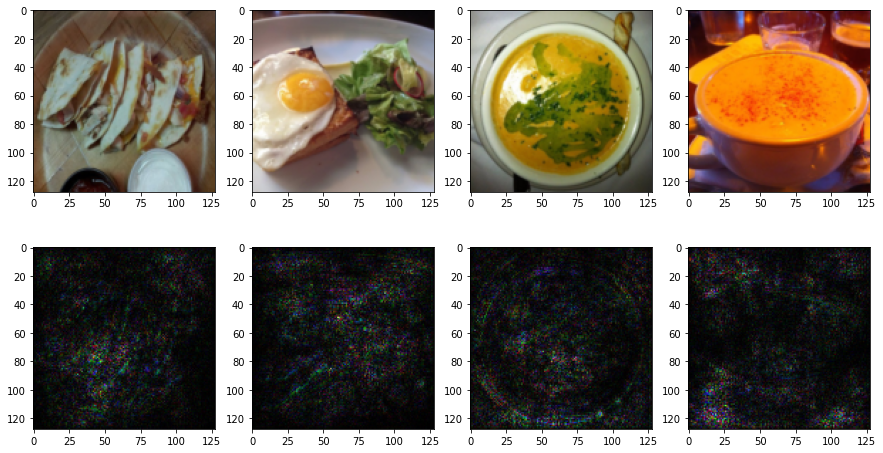

In [13]:
# axs 为fig对象列表
fig, axs = plt.subplots(2, len(img_indices), figsize = (15, 8))
for i in range(len(img_indices)):
    # notes: tensor 设置了grad，需要detach取出
    axs[0][i].imshow(data[i].detach().permute([1, 2, 0]).numpy())
    axs[1][i].imshow(saliency_map[i])

## 2.2 Filter explaination

Filter可视化有两种：
- Layer Activation可视化
- Filter可视化

第一种是可视化输入经过层次后的输出，目的是观察经过某个filter卷积之后，输入变成的x变成什么样子。实现需要利用pytorch的hook机制，其实就是回调，在该层次上注册事件，每当运行该层次，返回层次输出。

第二种是Filter可视化，我们知道，Filter其实是一个很小的patch（3 * 3），这种可视化不好作，人们想到的解决方法是，找一张图片能够最大激活该Filter，输出最大。也就是说，weight固定，我们需要对输入x进行梯度下降，找到x。


In [0]:
def get_activation(model, x, layer_id):
    def hook(model, input, output):
        global activation
        activation = output

    model.eval()
    handle = model.cnn[layer_id].register_forward_hook(hook)
    model(x.cuda())
    handle.remove()
    return activation.detach().permute([0,2,3,1]).cpu().numpy()

def get_filter_visualization(x, model, filter_id, layer_id = 12, iter = 10, learning_rate = 0.001):
    def hook(model, input, output):
        global activation
        activation = output
    handle = model.cnn[layer_id].register_forward_hook(hook)

    model.eval()
    x = x.cuda()
    x.requires_grad = True
    opitimizer = torch.optim.Adam([x], learning_rate)

    for i in range(iter):
        opitimizer.zero_grad()
        model(x)
        loss = -torch.sum(activation[:,filter_id, :, :])
        loss.backward()
        opitimizer.step()
    handle.remove()

    return x.detach().permute([0, 2, 3, 1]).cpu().numpy()[0]

In [0]:
learning_rate = 0.1
iter = 100
filter_id = 0
layer_id = 8
img_indices = [83, 4218, 8599, 8598]
data, labels = train_set.get_batch(img_indices)
filter_activation = get_activation(model, data, layer_id)
filter_visualization = get_filter_visualization(data, model, filter_id, layer_id = layer_id, iter = iter, learning_rate = learning_rate)

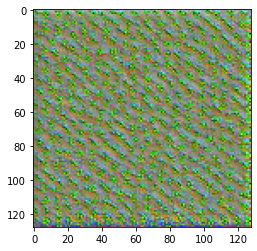

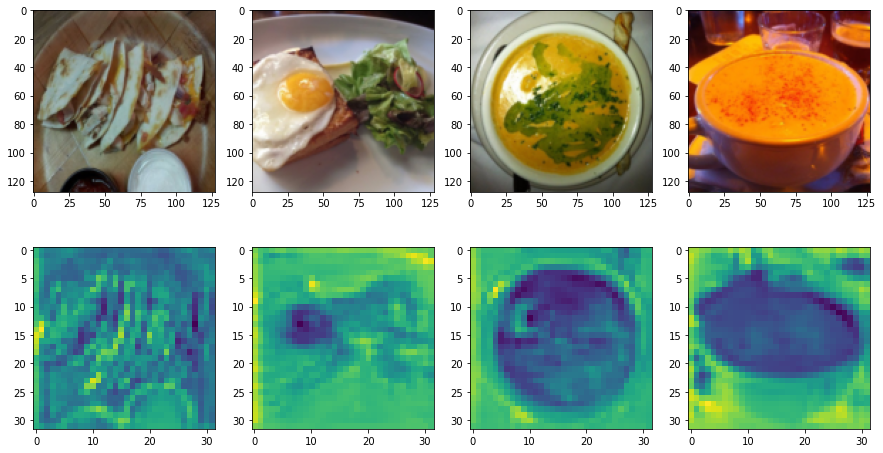

In [123]:
plt.imshow(normalize(filter_visualization))
plt.show()
# notes 多图可视化
# axs 为fig对象列表
fig, axs = plt.subplots(2, len(img_indices), figsize = (15, 8))
for i in range(len(img_indices)):
    # notes: tensor 设置了grad，需要detach取出
    axs[0][i].imshow(data[i].detach().permute([1, 2, 0]).numpy())
    axs[1][i].imshow(filter_activation[i,:,:,1])

In [17]:
model

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### 结论

filter 可视化有些意义不明，因为本来就是某些花纹或者抽象特征。

从filter activation的可视化来看，即使到了后期512 x 8 x 8， 8 x 8 依然在空间上和原图保持一致性。我之前以为多通道混合，到了后面的卷积层无法直观理解，这是错的。



## 2.3 Lime

利用线性模型解释复杂模型。

探究模型对输入数据的哪些局部更感兴趣。

- 复杂模型预测，保存结果
- 切分每个输入数据
- 使用线性模型拟合，切块数据和预测结果之间的关系


In [18]:
!pip install lime==0.1.1.37
from skimage.segmentation import slic
from lime import lime_image

     |████████████████████████████████| 276kB 3.5MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=dca87b6feec41399ccee8f2ac9c04d539774ffeb3ffbc599f020c34c029899d4
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=29e27824a78bfefbb824e23c513b85ddf8e6c39a74a7940212b287eab150c7dc
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


In [0]:
def predict(input_):
    model.eval()
    input_ = torch.tensor(input_, dtype = torch.float32).permute(0, 3, 1, 2).cuda()
    output_ = model(input_)
    return output_.detach().cpu().numpy()

def segmentation(input_):
    return slic(input_, n_segments = 200, compactness = 1, sigma = 1)

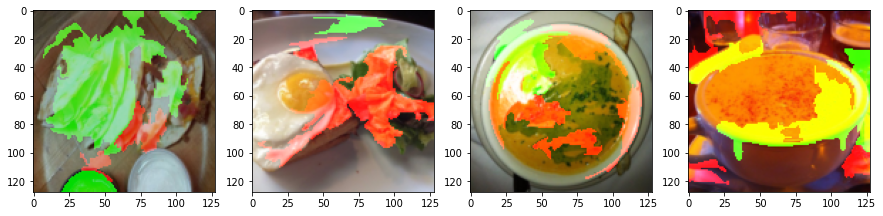

In [20]:
fig, axs = plt.subplots(1, 4, figsize = (15, 8))

for idx, (x, y) in enumerate(zip(data, labels)):
    x = x.permute(1, 2, 0).numpy().astype(np.double)
    # create explainer
    explainer = lime_image.LimeImageExplainer()
    # explain
    exp = explainer.explain_instance(image = x, classifier_fn = predict, segmentation_fn = segmentation, top_labels=11)
    # visualize
    img, mask = exp.get_image_and_mask(
                            label = y.item(),
                            positive_only = False,# 只显示正相关segment
                            hide_rest = False, # 隐藏其他部分
                            num_features = 11,
                            min_weight = 0.05
    )
    axs[idx].imshow(img)

# 3. 实验


- (2%) 從作業三可以發現，使用 CNN 的確有些好處，試繪出其 saliency maps，觀察模型在做 classification 時，是 focus 在圖片的哪些部份？
- (3%) 承(1) 利用上課所提到的 gradient ascent 方法，觀察特定層的filter最容易被哪種圖片 activate 與觀察 filter 的 output。
- (2%) 請使用 Lime 套件分析你的模型對於各種食物的判斷方式，並解釋為何你的模型在某些 label 表現得特別好 (可以搭配作業三的 Confusion Matrix)。
- (3%) [自由發揮] 請同學自行搜尋或參考上課曾提及的內容，實作任一種方式來觀察 CNN 模型的訓練，並說明你的實作方法及呈現 visualization 的結果。(請附上 reference


## 3.2 标签与识别区域

研究各个标签和识别区域之间的关系。

In [0]:
from PIL import  Image
#notes: Lazy loading dataset
class ImgDataset(Dataset):
    def __init__(self, img_dir, mode):
        self.mode = mode
        img_paths = sorted(os.listdir(img_dir))
        self.transform = transforms.Compose([
                                                transforms.Resize((128, 128)),                                 
                                                transforms.ToTensor(),
        ])
        
        if mode == 'train':
            labels = [int(img.split('_')[0]) for img in img_paths]
            self.labels = np.array(labels, dtype = np.int8)
            self.transform = transforms.Compose([
                                        transforms.Resize((128, 128)),
                                        # transforms.RandomHorizontalFlip(), 
                                        # transforms.RandomRotation(15), 
                                        transforms.ToTensor(), #將圖片轉成 Tensor，並把數值normalize到[0,1](data normalization)
            ])
        self.img_paths = [os.path.join(img_dir, x) for x in img_paths]

    def __getitem__(self, idx):
        x = Image.open(self.img_paths[idx])
        x = self.transform(x)
        if self.mode == 'train':
            return x, self.labels[idx]
        return x
    
    def __len__(self):
        return len(self.img_paths)

    def get_batch(self, indices):
        if self.mode is not 'train':
            return
        x_list = []
        y_list = []
        for idx in indices:
            x, y = self.__getitem__(idx)
            x_list.append(x)
            y_list.append(y)

        return torch.stack(x_list), torch.tensor(y_list)

    def get_batch_of(self, idx, n):
        indices = np.argwhere(self.labels == idx).squeeze()
        np.random.shuffle(indices)
        indices = indices[:n]
        print(indices.shape)
        return self.get_batch(indices)

def muti_plot(col, imgs_list=[]):
    n_list = len(imgs_list)
    row = int((imgs_list[0].shape[0] + col - 1) / col)
    print(row)
    fig, axs = plt.subplots(row*n_list, col, figsize=(15, 15))
    i = 0
    for r in range(row):
        for c in range(col):
            if i >= imgs_list[0].shape[0]:
                break
            for j in range(n_list):
                # print("r {} c {} i {}".format(r * n_list +j, c, i))
                axs[r * n_list +j][c].imshow(imgs_list[j][i])
            i += 1
            
    plt.show()

- 0: 披萨，集中在披萨主体上， 从混淆矩阵来看，容易被错认为油炸、蛋、海鲜，这非常正常，因为披萨和这三者都有点像
- 1: 奶 ，区域集中不明显，奶制品的形态太多，奶酪，牛奶，黄油，这个分类本身非常难识别。容易被误认为蛋制品、绿色食品、海鲜、甜品
- 2: 甜品，集中在主体上，容易被误认为油炸和海鲜
- 3: 蛋 ，集中在主体及面包上，对蛋白很敏感。识别率尚可。
- 4: 油炸，集中在主体上，识别率尚可。
- 5: 肉制，集中于主体，识别率尚可。
- 6: 面 ，集中于主体，但是大量被误认为饭
- 7: 饭 ，集中于主体，主要就是和面混淆，没有很好捕获纹理特征。
- 8: 海鲜，集中于贝壳，主体，很多食物都误认为是它
- 9: 粥 ，集中于碗状、主体，对于碗很敏感，识别率尚可
-10: 绿色，绿叶部分，识别率极高

(8,)


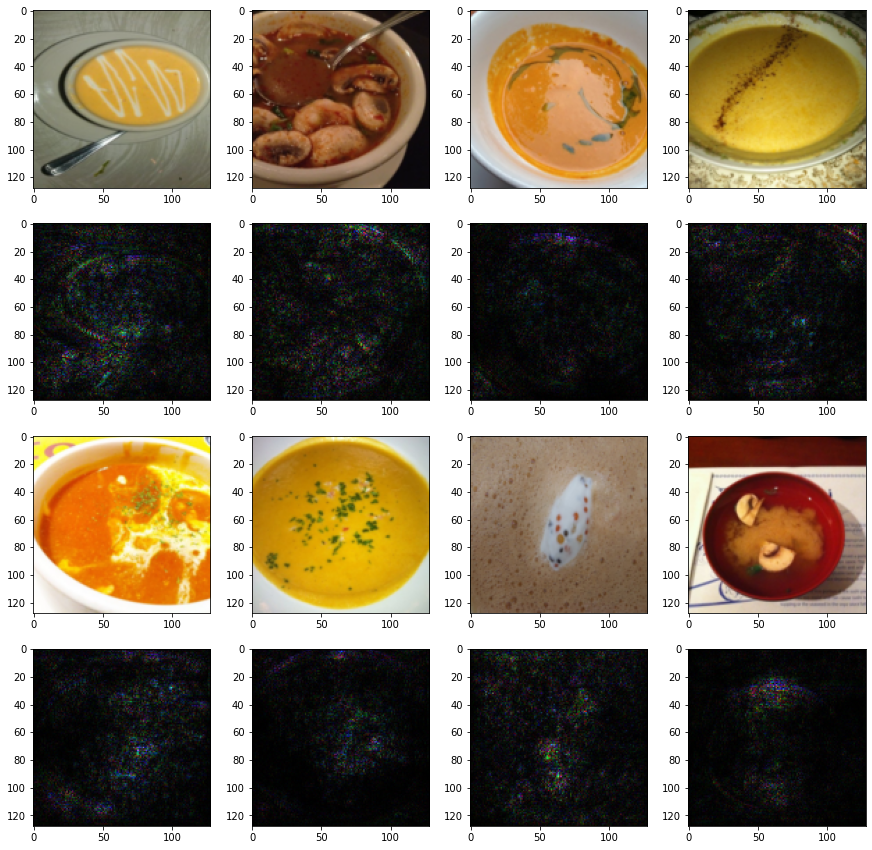

In [121]:
img_dir = './food-11/training'
train_set= ImgDataset(os.path.join(data_path, 'training'), mode = 'train')
images, labels = train_set.get_batch_of(9, 8)
saliency_map = get_saliency_map(model, images, labels)
muti_plot(4,[images.permute(0, 2, 3, 1).numpy(), saliency_map])

## 3.3 filter 通道激活观察

观察第8层（cnn第二层）输出。

notes: 技巧，可视化relu后的层次更容易观察，如下，这个filter显然对一些边缘比较感兴趣。（layer 7， filter 3）

观察越靠后的层次发现，每个filter激活的区域越来越小，可能是图上的某个点，这说明特征越来越抽象。（layer 14， filter 5）

也就是说，后面的某些filter可能只检测某个特征（比如眼球）。

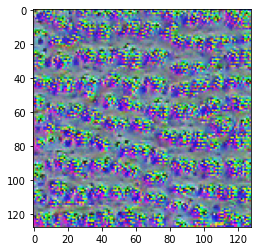

1


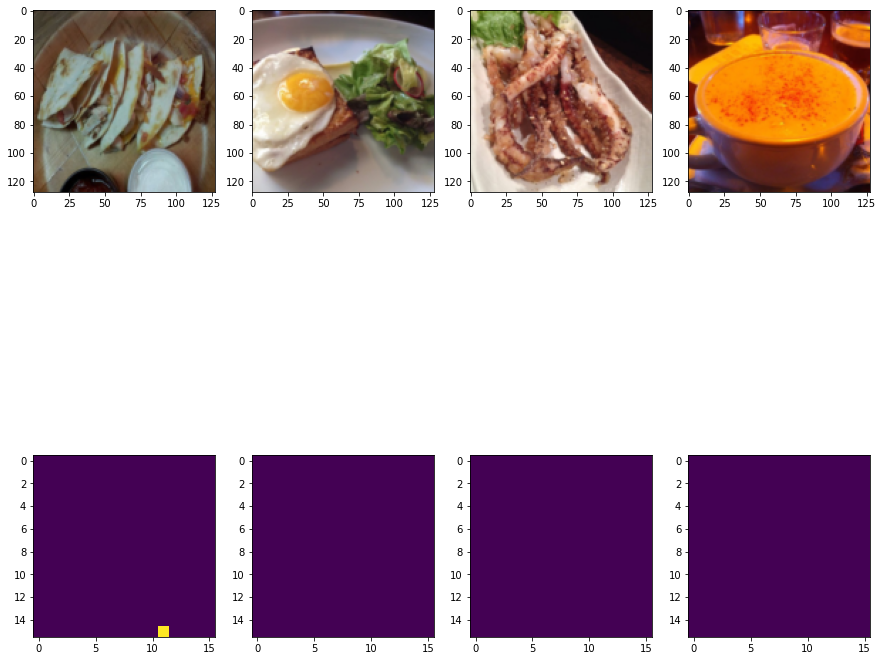

In [158]:
learning_rate = 0.1
iter = 100
filter_id = 5
layer_id = 14
# data, labels = train_set.get_batch_of(7, 4)
img_indices = [83, 4218, 4707, 8598]
data, labels = train_set.get_batch(img_indices)
filter_activation = get_activation(model, data, layer_id)
filter_visualization = get_filter_visualization(data, model, filter_id, layer_id = layer_id, iter = iter, learning_rate = learning_rate)
plt.imshow(normalize(filter_visualization))
plt.show()
muti_plot(4, [data.permute(0, 2 , 3, 1).numpy(), filter_activation[:, :, :, filter_id].squeeze()])

In [134]:
model

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


## 3.4 Lime 标签与识别区域关系 二

理论我能理解，但是我认为这是一种好的解释手段，但不是一种好的分析手段，确实存在部分结果符合预期，但容易观察到其他结果，误导分析。

In [0]:
def lime_saliency_map(data, labels):
    ig, axs = plt.subplots(1, 4, figsize = (15, 8))

    for idx, (x, y) in enumerate(zip(data, labels)):
        x = x.permute(1, 2, 0).numpy().astype(np.double)
        # create explainer
        explainer = lime_image.LimeImageExplainer()
        # explain
        exp = explainer.explain_instance(image = x, classifier_fn = predict, segmentation_fn = segmentation, top_labels=11)
        # visualize
        img, mask = exp.get_image_and_mask(
                                label = y.item(),
                                positive_only = False,# 只显示正相关segment
                                hide_rest = False, # 隐藏其他部分
                                num_features = 20,
                                min_weight = 0.05
        )
        axs[idx].imshow(img)

(4,)


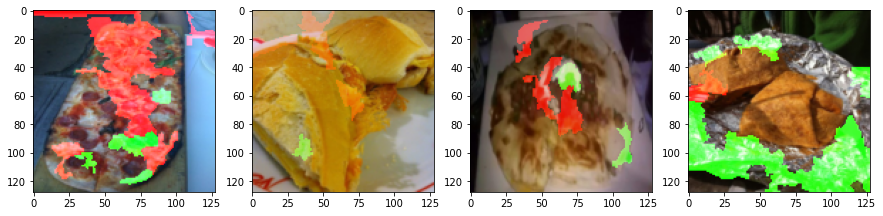

In [165]:
data, labels = train_set.get_batch_of(0, 4)
lime_saliency_map(data, labels)

(4,)


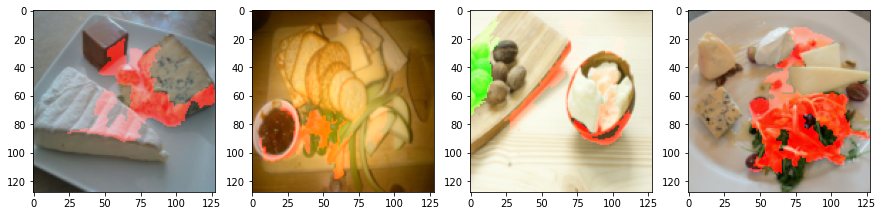

In [166]:
data, labels = train_set.get_batch_of(1, 4)
lime_saliency_map(data, labels)

(4,)


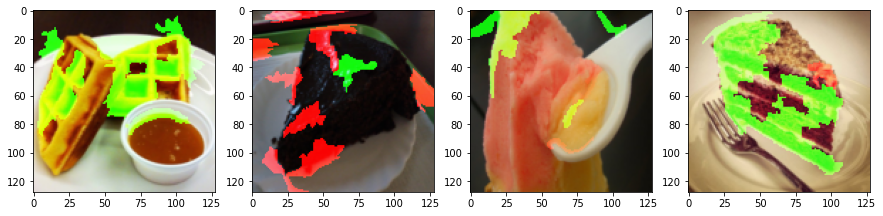

In [168]:
data, labels = train_set.get_batch_of(2, 4)
lime_saliency_map(data, labels)

(4,)


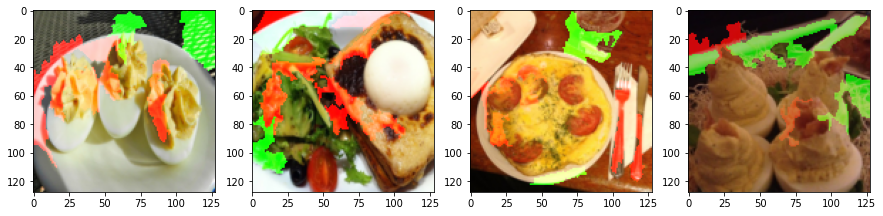

In [167]:
data, labels = train_set.get_batch_of(3, 4)
lime_saliency_map(data, labels)

(4,)


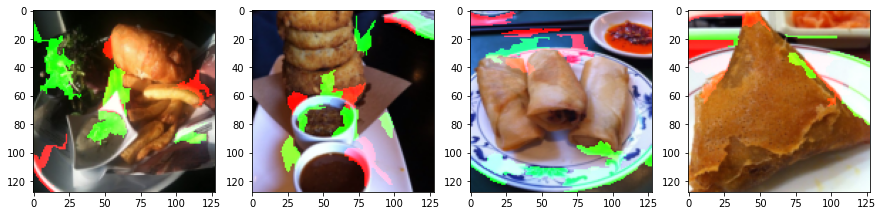

In [169]:
data, labels = train_set.get_batch_of(4, 4)
lime_saliency_map(data, labels)

(4,)


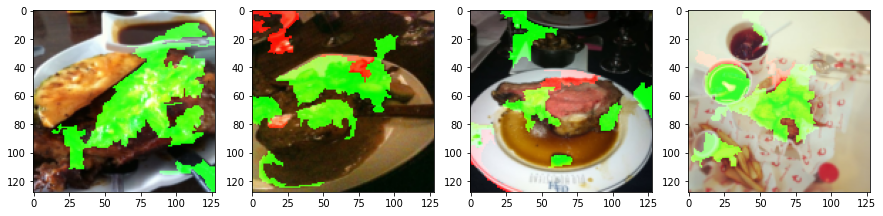

In [170]:
data, labels = train_set.get_batch_of(5, 4)
lime_saliency_map(data, labels)

(4,)


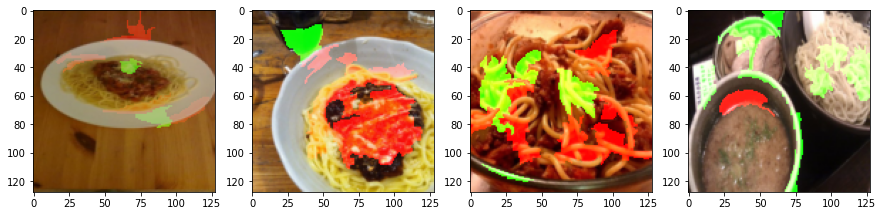

In [171]:
data, labels = train_set.get_batch_of(6, 4)
lime_saliency_map(data, labels)

(4,)


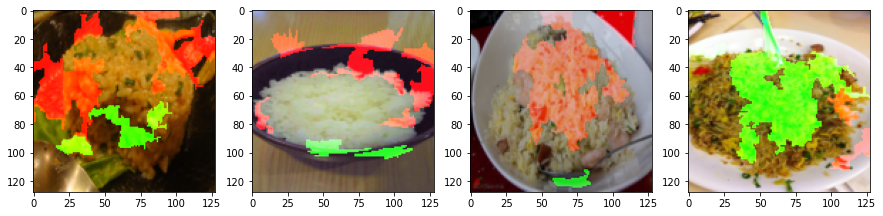

In [172]:
data, labels = train_set.get_batch_of(7, 4)
lime_saliency_map(data, labels)

(4,)


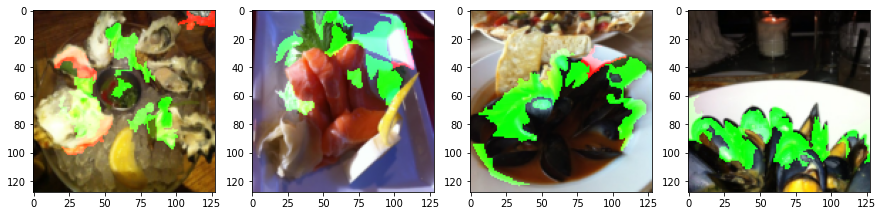

In [173]:
data, labels = train_set.get_batch_of(8, 4)
lime_saliency_map(data, labels)

(4,)


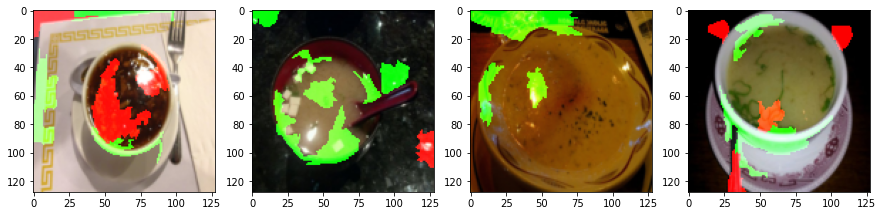

In [174]:
data, labels = train_set.get_batch_of(9, 4)
lime_saliency_map(data, labels)

(4,)


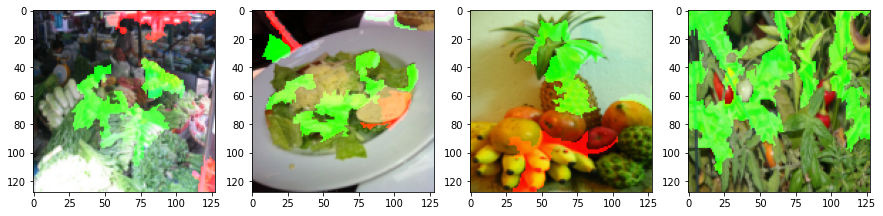

In [175]:
data, labels = train_set.get_batch_of(10, 4)
lime_saliency_map(data, labels)

## 3.5 Deep Dream

……pass